In [18]:
#imports
import numpy as np
import pandas as pd
import nltk
from nltk.stem.snowball import SnowballStemmer
import re
import os
import codecs
from sklearn import feature_extraction
from sklearn.cluster import KMeans
%matplotlib inline 

In [2]:
#import data
voqs = pd.read_excel("./test_set_11_20.xlsx", sheetname=0)
voqs.columns = ["odino", "make_mod", "ecode", "compdesc", "cdescr", "defect", "datea", "modelyr", "engine_code"]
voqs.head()

,odino,make_mod,ecode,compdesc,cdescr,defect,datea,modelyr,engine_code
0,11046596,bmw; k1300 gt; 2010; motorcycle; wb1053906az,k44,fuel/propulsion system,tl* the contact owns a 2010 bmw k1300 gt motor...,1747 - (moto) quick-connect fuel line issue,2017-11-16,2010,NaN
1,11045158,bmw; 323i; 1998; car; m52; wbabj8321we,e36,air bags; engine; unknown or other,"a driver, on a 5 lane st, in a center turn lan...",1002 - airbag related injuries,2017-11-10,1998,m52
2,11046601,bmw; 320i; 2016; car; n20; wba8e1g58gn,f30,electrical system; power train; service brakes,car has shut off while in motion and indicator...,1112 - multiple issues,2017-11-16,2016,n20
3,11046895,bmw; 760li; 2006; car; n73; wbahn03566d,e66,electrical system; power train; suspension,"car stops on freeway, numerous problems with s...",1112 - multiple issues,2017-11-17,2006,n73
4,11046876,bmw; x3; 2013; car; n20; 5uxwx9c54d0,f25,exterior lighting,tail lights will fail with no warning light or...,1012 - tail light issue,2017-11-16,2013,n20


In [3]:
#trim sets for what you need
narratives = voqs['cdescr'].values.tolist()
defect_labels = voqs['defect'].values.tolist()
print(narratives[0][:200]) 

tl* the contact owns a 2010 bmw k1300 gt motorcycle. while driving approximately 50 mph, the contact noticed that his pants were wet from fuel that was leaking from a plastic connector line. the conta


In [17]:
len(narratives)

15489

In [4]:
#not finalized
#stop words and stemming instanced in respective variables
stopwords = nltk.corpus.stopwords.words('english')
stemmer = SnowballStemmer("english")

In [5]:
# brandon rose's functions for tokenizing and stemming

def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as its own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [6]:
#create two massive lists of total vocabulary in all the voqs

totalvocab_stemmed = []
totalvocab_tokenized = []
for i in narratives:
    allwords_stemmed = tokenize_and_stem(i) #for each item in 'narratives', tokenize/stem
    totalvocab_stemmed.extend(allwords_stemmed) #extend the 'totalvocab_stemmed' list
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

In [7]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
print ('there are ' + str(vocab_frame.shape[0]) + ' items in vocab_frame')

there are 1439449 items in vocab_frame


In [8]:
#convert documents to tfidf matrix
from sklearn.feature_extraction.text import TfidfVectorizer

#define vectorizer parameters
#word should not be in more than 80% of the documents
#word should be in at least 5% of the documents
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.05, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(narratives) #fit the vectorizer to synopses

print(tfidf_matrix.shape)

Wall time: 40.4 s
(15489, 191)


In [10]:
#inspect the terms that are in the tfidf matrix
#need to delete * terms that are annotations on the entry. These are counted and then bias the clustering. 
terms = tfidf_vectorizer.get_feature_names()
terms

["'s",
 '*tr',
 'abl',
 'accid',
 'air',
 'air bag',
 'airbag',
 'ani',
 'approxim',
 'approxim failur',
 'approxim failur mileag',
 'assist',
 'avail',
 'awar',
 'bag',
 'becaus',
 'befor',
 'bmw',
 'brake',
 'came',
 'campaign',
 'campaign number',
 'car',
 'caus',
 'check',
 'come',
 'complaint',
 'complet',
 'contact',
 'contact bmw',
 'contact experienc',
 'contact experienc failur',
 'contact receiv',
 'contact receiv notif',
 'contact state',
 'contact state manufactur',
 'continu',
 'control',
 'cooper',
 'cost',
 'cover',
 'current',
 'current mileag',
 'danger',
 'day',
 'dealer',
 'dealership',
 'defect',
 'diagnos',
 'did',
 'doe',
 'door',
 'drive',
 'driver',
 'engin',
 'exceed',
 'exceed reason',
 'exceed reason time',
 'experienc',
 'experienc failur',
 'fail',
 'failur',
 'failur mileag',
 'fix',
 'fuel',
 'happen',
 'highway',
 'howev',
 'illumin',
 'includ',
 'indic',
 'inform',
 'issu',
 'just',
 'know',
 'later',
 'leak',
 'left',
 'light',
 'like',
 'lock',
 'make

In [11]:
#cosine similarity if necessary later
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)
dist

array([[  0.00000000e+00,   9.53210720e-01,   9.11615411e-01, ...,
          9.72410797e-01,   9.21382926e-01,   8.70589131e-01],
       [  9.53210720e-01,  -2.22044605e-16,   8.05782872e-01, ...,
          7.77064062e-01,   8.35598335e-01,   8.80717840e-01],
       [  9.11615411e-01,   8.05782872e-01,  -2.22044605e-16, ...,
          8.15802525e-01,   9.60187772e-01,   9.28796428e-01],
       ..., 
       [  9.72410797e-01,   7.77064062e-01,   8.15802525e-01, ...,
         -2.22044605e-16,   5.16912825e-01,   7.07608950e-01],
       [  9.21382926e-01,   8.35598335e-01,   9.60187772e-01, ...,
          5.16912825e-01,  -2.22044605e-16,   6.45126648e-01],
       [  8.70589131e-01,   8.80717840e-01,   9.28796428e-01, ...,
          7.07608950e-01,   6.45126648e-01,  -2.22044605e-16]])

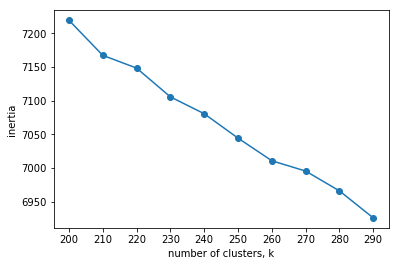

In [19]:
#compute within cluster sum of squares (inertia) for each k between 200 and 300 and plot to pick the best K
import matplotlib.pyplot as plt

ks = range(200, 300, 10)
inertia_values = []

for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters = k)
    
    # Fit model to samples
    model.fit(tfidf_matrix)
    
    # Append the inertia to the list of inertias
    inertia_values.append(model.inertia_)
    
# Plot ks vs inertias
plt.plot(ks, inertia_values, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.savefig('inertia2.jpg')
plt.show()

In [20]:
#need to redo with k closer to the number of IR defects. How many should I choose? Do frequency and see what the 
#less frequent codes are. 

In [21]:
#try an optimized clustering 

from sklearn.cluster import KMeans

num_clusters = 250

km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

Wall time: 1min 56s


In [22]:
#add cluster labels onto original dataframe
voqs['clusters'] = clusters
voqs

,odino,make_mod,ecode,compdesc,cdescr,defect,datea,modelyr,engine_code,clusters
0,11046596,bmw; k1300 gt; 2010; motorcycle; wb1053906az,k44,fuel/propulsion system,tl* the contact owns a 2010 bmw k1300 gt motor...,1747 - (moto) quick-connect fuel line issue,2017-11-16,2010,NaN,204
1,11045158,bmw; 323i; 1998; car; m52; wbabj8321we,e36,air bags; engine; unknown or other,"a driver, on a 5 lane st, in a center turn lan...",1002 - airbag related injuries,2017-11-10,1998,m52,109
2,11046601,bmw; 320i; 2016; car; n20; wba8e1g58gn,f30,electrical system; power train; service brakes,car has shut off while in motion and indicator...,1112 - multiple issues,2017-11-16,2016,n20,142
3,11046895,bmw; 760li; 2006; car; n73; wbahn03566d,e66,electrical system; power train; suspension,"car stops on freeway, numerous problems with s...",1112 - multiple issues,2017-11-17,2006,n73,156
4,11046876,bmw; x3; 2013; car; n20; 5uxwx9c54d0,f25,exterior lighting,tail lights will fail with no warning light or...,1012 - tail light issue,2017-11-16,2013,n20,22
5,11046635,bmw; r1200 r; 2007; motorcycle; wb10398007z,k27,fuel/propulsion system,driving on the highway with fuel indicator sho...,1710 - (moto) fuel gauge read incorrectly,2017-11-16,2007,NaN,30
6,11046571,bmw; 3 series; 2007; car; n52k; wbavc93517k,e90,engine,vehicle completely shut down while driving on ...,1042 - defective vanos bolts,2017-11-16,2007,n52k,75
7,11046648,bmw; 335i; 2009; car; n54; wbawl73589p,e93,air bags; engine; fuel/propulsion system,i went to the bmw dealership (to have the seve...,1467 - no replacement parts,2017-11-16,2009,n54,238
8,11046486,bmw; x5 sav; 2009; car; m57y; 5uxff03593l,e70,engine; fuel/propulsion system,i am writing in regards to a technical service...,1467 - no replacement parts,2017-11-16,2009,m57y,38
9,11046505,bmw; 530i; 2017; car; b46o; wbaja5c33hg,g30,visibility/wiper,tl* the contact owns a 2017 (na) bmw 530i. whi...,1746 - heads up display causes glare on windsh...,2017-11-16,2017,b46o,58


In [23]:
voqs


,odino,make_mod,ecode,compdesc,cdescr,defect,datea,modelyr,engine_code,clusters
0,11046596,bmw; k1300 gt; 2010; motorcycle; wb1053906az,k44,fuel/propulsion system,tl* the contact owns a 2010 bmw k1300 gt motor...,1747 - (moto) quick-connect fuel line issue,2017-11-16,2010,NaN,204
1,11045158,bmw; 323i; 1998; car; m52; wbabj8321we,e36,air bags; engine; unknown or other,"a driver, on a 5 lane st, in a center turn lan...",1002 - airbag related injuries,2017-11-10,1998,m52,109
2,11046601,bmw; 320i; 2016; car; n20; wba8e1g58gn,f30,electrical system; power train; service brakes,car has shut off while in motion and indicator...,1112 - multiple issues,2017-11-16,2016,n20,142
3,11046895,bmw; 760li; 2006; car; n73; wbahn03566d,e66,electrical system; power train; suspension,"car stops on freeway, numerous problems with s...",1112 - multiple issues,2017-11-17,2006,n73,156
4,11046876,bmw; x3; 2013; car; n20; 5uxwx9c54d0,f25,exterior lighting,tail lights will fail with no warning light or...,1012 - tail light issue,2017-11-16,2013,n20,22
5,11046635,bmw; r1200 r; 2007; motorcycle; wb10398007z,k27,fuel/propulsion system,driving on the highway with fuel indicator sho...,1710 - (moto) fuel gauge read incorrectly,2017-11-16,2007,NaN,30
6,11046571,bmw; 3 series; 2007; car; n52k; wbavc93517k,e90,engine,vehicle completely shut down while driving on ...,1042 - defective vanos bolts,2017-11-16,2007,n52k,75
7,11046648,bmw; 335i; 2009; car; n54; wbawl73589p,e93,air bags; engine; fuel/propulsion system,i went to the bmw dealership (to have the seve...,1467 - no replacement parts,2017-11-16,2009,n54,238
8,11046486,bmw; x5 sav; 2009; car; m57y; 5uxff03593l,e70,engine; fuel/propulsion system,i am writing in regards to a technical service...,1467 - no replacement parts,2017-11-16,2009,m57y,38
9,11046505,bmw; 530i; 2017; car; b46o; wbaja5c33hg,g30,visibility/wiper,tl* the contact owns a 2017 (na) bmw 530i. whi...,1746 - heads up display causes glare on windsh...,2017-11-16,2017,b46o,58


### Milestone Suggestions for Improvements

-Check how many comments have no words left after running vectorizer.
-Histogram of words before vectorizer and after preprocessing steps. 
-Dimensionality may be a little high, see if you can do PCA (maybe) to reduce dimensions
-Start with a lower k (not a clear elbow): 1 to 50 by 5 and see if an elbow shows up. Do silhouette score too.
-Unusual to use K means for this high of a k.
-Try LDA (topic modeling) - gensim would be a good method to use. 
-LSA may be easier too.

### First Run: Latent Dirichlet Allocation

In [9]:
########################try LDA#############################
from gensim import corpora, models, similarities 

#tokenize
%time tokenized_text = [tokenize_and_stem(text) for text in narratives]

#remove stop words
%time texts = [[word for word in text if word not in stopwords] for text in tokenized_text]

Wall time: 33.9 s
Wall time: 2.28 s


In [11]:
len(texts)

15489

In [12]:
#create a Gensim dictionary from the texts
dictionary = corpora.Dictionary(texts)

#remove extremes (similar to the min/max df step used when creating the tf-idf matrix)
dictionary.filter_extremes(no_below=1, no_above=0.8)

#convert the dictionary to a bag of words corpus for reference
corpus = [dictionary.doc2bow(text) for text in texts]

In [14]:
len(corpus)

15489

In [17]:
#run the LDA model from gensim. Try with a low number of topics, like 10 topics
%time lda = models.LdaModel(corpus, num_topics=10, id2word=dictionary,update_every=5,chunksize=20000,passes=50)

Wall time: 36min 11s


In [18]:
lda.show_topics()

[(0,
  '0.096*"air" + 0.091*"bag" + 0.075*"passeng" + 0.053*"seat" + 0.029*"sensor" + 0.027*"front" + 0.026*"light" + 0.024*"side" + 0.022*"illumin" + 0.021*"deploy"'),
 (1,
  '0.084*"vehicl" + 0.076*"contact" + 0.063*"failur" + 0.034*"mileag" + 0.031*"state" + 0.027*"repair" + 0.024*"manufactur" + 0.024*"dealer" + 0.024*"tl*" + 0.022*"bmw"'),
 (2,
  '0.042*"fuel" + 0.021*"engin" + 0.020*"pump" + 0.019*"bmw" + 0.017*"motorcycl" + 0.015*"leak" + 0.013*"*tr" + 0.013*"replac" + 0.012*"failur" + 0.011*"bike"'),
 (3,
  '0.051*"car" + 0.014*"engin" + 0.014*"drive" + 0.013*"time" + 0.012*"problem" + 0.011*"bmw" + 0.009*"start" + 0.009*"mile" + 0.008*"issu" + 0.008*"stop"'),
 (4,
  '0.055*"door" + 0.043*"tire" + 0.023*"driver" + 0.022*"lock" + 0.022*"open" + 0.016*"car" + 0.015*"side" + 0.015*"unlock" + 0.014*"key" + 0.012*"window"'),
 (5,
  '0.095*"contact" + 0.052*"part" + 0.046*"recal" + 0.045*"repair" + 0.042*"manufactur" + 0.028*"number" + 0.027*"nhtsa" + 0.026*"campaign" + 0.026*"bmw" + 